In [71]:
import h5py
import torch
from torch import nn
import tifffile
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

In [3]:
import os
import random

import mmcv
import numpy as np
from mmdet.apis import inference_detector, init_detector
from mmengine.config import Config, ConfigDict
from mmengine.logging import print_log
from mmengine.utils import ProgressBar
from slicing import slice_image
from mmyolo_utils_large_image import merge_results_by_nms, shift_predictions

In [4]:
def imgPreProcess_simpleClip(path_img, debug=False):
    image = tifffile.imread(path_img)
    if image.shape[-1] != 125:
        image = image.transpose(1,2,0)
    if debug:
        image = np.clip(image[:,:,[55,28,7]], 0, 10000)
    else:
        image = np.clip(image, 0, 10000)
    return image

In [66]:
class ToTensor():
    '''
    转为tensor，并且转移到显存中（如果使用显卡）
    '''
    def __init__(self, device):
        self.device = device
    
    def __call__(self, image:np.ndarray):
        image = image.transpose(2,0,1)
        image = torch.from_numpy(image).float().to(self.device)
        return image
    
class CropAndResize():
    '''
    随机翻转
    '''
    def __init__(self, size:int = 96):
        '''
        @param:size:目标大小
        '''
        self.size = size
    
    def __call__(self, image:torch.tensor):
        '''
        @param:image:图像
        '''
        image = transforms.functional.center_crop(image, min(image.shape[-2:]))
        image = transforms.functional.resize(image, self.size)
        return image

In [75]:
def regPredict(model_reg, img, boxes):
    model_reg.eval()
    imgs = []
    for box in boxes:
        c1,r1,c2,r2 = box
        c1,r1,c2,r2 = int(c1.item()),int(r1.item()),int(c2.item()),int(r2.item())
        img_crop = img[r1:r2+1,c1:c2+1,:].astype('float')
        img_crop = ToTensor(DEVICE)(img_crop)
        img_crop = CropAndResize()(img_crop)
        imgs.append(img_crop.unsqueeze(0))
    imgs = torch.concat(imgs)
    with torch.no_grad():
        result_reg = model_reg(imgs).cpu().numpy()
    result = np.concatenate([boxes.cpu(), result_reg],axis=1,dtype='float')
    return result

In [10]:
# 检测模型
config_file = "../mmdet/work_dirs/faster-rcnn_r50_pafpn_2xb16_e100_cau/faster-rcnn_r50_pafpn_2xb16_e100_cau.py"
checkpoint_file = "../mmdet/work_dirs/faster-rcnn_r50_pafpn_2xb16_e100_cau/epoch_100.pth"
model = init_detector(config_file, checkpoint_file, device="cuda:0")

In [72]:
# 回归模型
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path = '../models_reg/models_18_0923/2023092319_Loss_0.003006.pt'
model_reg = models.resnet18(weights=None)
model_reg.conv1 = nn.Conv2d(125, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_reg.fc = nn.Sequential(nn.Linear(512,1),nn.Sigmoid())
model_reg.to(DEVICE)
model_reg.load_state_dict(torch.load(model_path))
model_reg.eval()
print('*** model reg 加载完毕 ***')

*** model reg 加载完毕 ***


In [163]:
path_image = '../data/imgs/ori_img_20211114.tif'
img = imgPreProcess_simpleClip(path_image, debug=False)
img_test_valid = img[2000:3000, 2000:3000, :].astype('int16')

In [164]:
# img_test_valid = np.load('full_map_predict.npy').astype('int16')

In [165]:
batch_size = 1
# arrange slices
height, width = img_test_valid.shape[:2]
sliced_image_object = slice_image(
    img_test_valid,
    slice_height=512,
    slice_width=512,
    auto_slice_resolution=False,
    overlap_height_ratio=0.5,
    overlap_width_ratio=0.5,
    Hyperspectral=True,
)

# perform sliced inference
slice_results = []
start = 0
while True:
    # prepare batch slices
    end = min(start + batch_size, len(sliced_image_object))
    images = []
    for sliced_image in sliced_image_object.images[start:end]:
        images.append(sliced_image)

    # forward the model
    print(images[0].shape)
    slice_results.extend(inference_detector(model, images))

    if end >= len(sliced_image_object):
        break
    start += batch_size

image_result = merge_results_by_nms(
    slice_results,
    sliced_image_object.starting_pixels,
    src_image_shape=(height, width),
    nms_cfg={
        'type': 'nms',
        'iou_threshold': 0.1
    })

(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)


In [121]:
# img_show = (img_test_valid[:,:,[7,28,55]]/10000*255*1.25).astype(np.uint8).copy()
# for box in image_result.pred_instances.bboxes:
#     c1,r1,c2,r2 = box
#     c1,r1,c2,r2 = int(c1.item()), int(r1.item()), int(c2.item()), int(r2.item())
#     cv.rectangle(img_show, (c1,r1), (c2,r2), (255,0,0), 1)

# plt.figure(0, (10,10), 100)
# plt.imshow(img_show)
# plt.show()

In [166]:
result_with_reg = regPredict(model_reg, img_test_valid, image_result.pred_instances.bboxes)
img_show = (img_test_valid[:,:,[7,28,55]]/10000*255*1).astype(np.uint8).copy()
img_show_with_reg = (img_show[...,::-1].copy()).astype('uint8')

for box in result_with_reg:
    c_min, r_min, c_max, r_max, reg = box
    c_min, r_min, c_max, r_max = int(c_min), int(r_min), int(c_max), int(r_max)
    cv.rectangle(
        img=img_show_with_reg,
        pt1=(c_min, r_min),
        pt2=(c_max, r_max),
        color=(255, 100, 100),
        thickness=1
    )
    text = f'{reg:.1%}'
    cv.putText(
        img_show_with_reg,
        text,
        org = (c_min,r_min+10),
        fontFace = cv.FONT_HERSHEY_SIMPLEX,
        fontScale = 0.4,
        color = (255, 100, 100),
        thickness = 1,
        lineType = cv.LINE_AA
    )

/HOME/scw6493/.conda/envs/cau/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


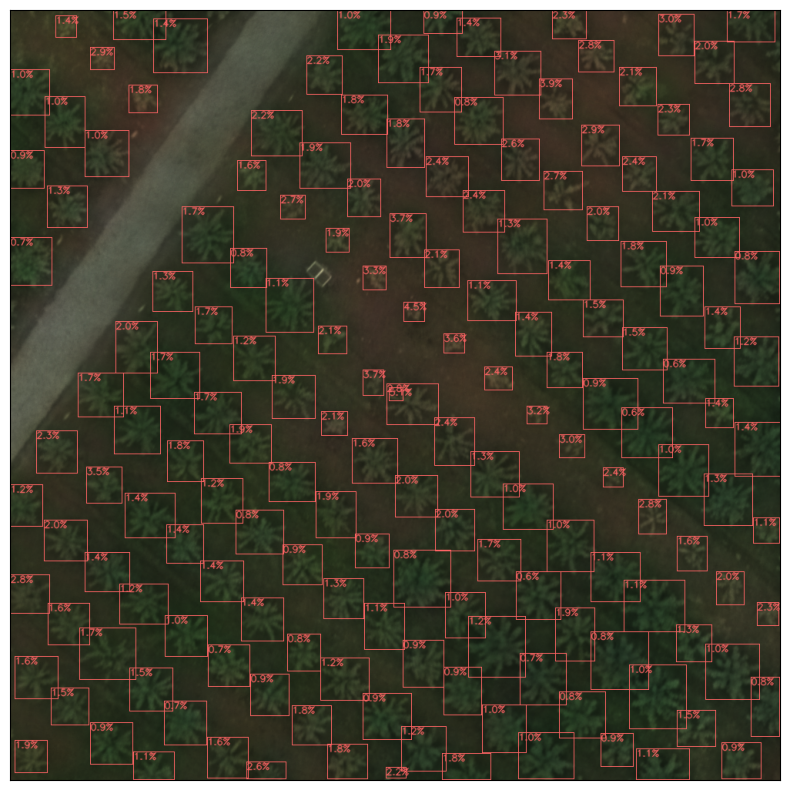

In [167]:
fig = plt.figure(0, (10,10),100)
ax = fig.add_subplot(111)
ax.imshow(img_show_with_reg)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
# plt.savefig('figs/results_20211114_fullmap.jpg')
plt.show()

In [116]:
img_debug = (img[:,:,[7,28,55]]/10000*255*1).astype(np.uint8).copy()

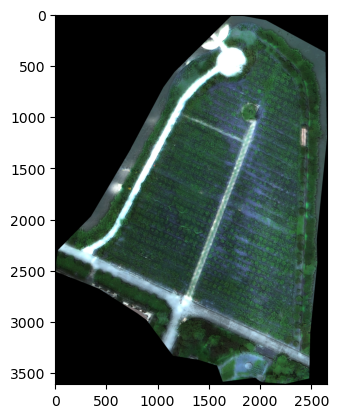

In [117]:
plt.imshow(img_debug)